In [2]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, models

#from imutils import paths
from pathlib import Path
import os, sys
import time
import copy

import pandas as pd
import matplotlib.pylab as plt
import numpy as np

# Local modules
from cub_tools.train import train_model
from cub_tools.visualize import imshow, visualize_model
from cub_tools.utils import unpickle, save_pickle
from cub_tools.transforms import makeAggresiveTransforms, makeDefaultTransforms, resizeCropTransforms

In [3]:
# Script runtime options
model = 'resnext101_32x8d'
root_dir = '..'
data_root_dir = os.path.join(root_dir, 'data')
model_root_dir = os.path.join(root_dir, 'models')
stages = ['test']


# Paths setup
data_dir = os.path.join(data_root_dir,'images')
output_dir = os.path.join(model_root_dir,'classification/{}'.format(model))
model_history = os.path.join(output_dir,'model_history.pkl')
model_file = os.path.join(output_dir, 'caltech_birds_{}_full.pth'.format(model))

In [7]:
class_report_df = pd.read_pickle(os.path.join(output_dir,'classification_report.pkl'))
confusion_matrix_df = pd.read_pickle(os.path.join(output_dir,'confusion_matrix.pkl'))
results_dict = unpickle(os.path.join(output_dir,'model_results.pkl'))

In [10]:
results_dict

{'labels truth': array([165, 147,  60, ...,  59, 149, 149]),
 'labels pred': array([165, 147,  60, ...,  59, 149, 149]),
 'scores pred': array([[-1.7585166 , -0.11528191, -0.7463226 , ..., -1.7708209 ,
         -2.4359295 ,  1.8208365 ],
        [-2.9826176 , -1.3202008 , -0.070005  , ...,  0.6403962 ,
         -1.6412712 ,  1.576707  ],
        [ 0.5541081 ,  0.8492918 ,  2.913691  , ...,  0.27884176,
         -1.1630446 , -0.7169441 ],
        ...,
        [ 1.4060245 ,  4.3461027 ,  4.666871  , ...,  0.16664435,
         -0.8458027 , -1.6676842 ],
        [-1.4359198 , -1.4477571 ,  0.49386078, ...,  2.7393074 ,
          1.0135219 , -1.9012471 ],
        [-0.44152918, -0.29678792,  0.7778146 , ...,  1.720044  ,
          0.02105246, -1.288324  ]], dtype=float32)}

In [24]:
np.unique(results_dict['labels truth'])

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [14]:
class_report_df.transpose().iloc[:-3].sort_values(by='precision')

,precision,recall,f1-score,support
144.Common_Tern,0.310345,0.300000,0.305085,30.0
059.California_Gull,0.363636,0.266667,0.307692,30.0
039.Least_Flycatcher,0.428571,0.517241,0.468750,29.0
027.Shiny_Cowbird,0.451613,0.466667,0.459016,30.0
029.American_Crow,0.473684,0.600000,0.529412,30.0
...,...,...,...,...
089.Hooded_Merganser,1.000000,0.800000,0.888889,30.0
093.Clark_Nutcracker,1.000000,1.000000,1.000000,30.0
101.White_Pelican,1.000000,1.000000,1.000000,20.0
148.Green_tailed_Towhee,1.000000,0.933333,0.965517,30.0


In [22]:
(results_dict['labels pred'][results_dict['labels truth'] == 144] == 142).sum()

11

In [63]:
results_dict['labels pred'][results_dict['labels truth'] == 144]

array([144, 142, 144, 142, 142, 144, 144, 142, 144, 144, 144, 142, 144,
       142, 144, 145, 142, 144, 144, 144, 145, 144, 144, 144, 142, 142,
       144, 144, 142, 142])

In [64]:
results_dict['scores pred'][ results_dict['labels truth'] == 144 ]

array([[-3.3429627 ,  0.7251591 ,  0.59537834, ...,  0.02755285,
        -1.9392877 , -1.0149053 ],
       [-2.7769406 , -0.39465445,  0.6162865 , ..., -0.11606643,
        -2.2832232 , -0.21664265],
       [-2.264396  ,  0.16455682,  1.3694369 , ...,  0.34178573,
        -2.1566696 , -0.73165804],
       ...,
       [-3.3998573 ,  0.770801  , -0.2875908 , ..., -0.84585065,
        -2.2864838 , -0.45284748],
       [-2.0238082 ,  1.709471  ,  1.1201454 , ..., -0.2929591 ,
        -1.6595067 , -0.39253372],
       [-1.9791722 ,  0.8082852 ,  1.2636262 , ...,  0.6080744 ,
        -2.7800767 , -0.9089626 ]], dtype=float32)

In [75]:
def getCLassMisPredictions(target_class, labels_truth, labels_predicted, scores_predicted, class_names=None):
    misClassDict = { 'scores_pred' : {}, 'labels_pred' : {}, 'mis_class_summary' : {} }
    misClassDict['labels_pred'] = labels_predicted[ labels_truth == target_class ]
    if scores_predicted is not None:
        misClassDict['scores_pred'] = scores_predicted[ labels_truth == target_class ]
    for predClass in np.unique(misClassDict['labels_pred']):
        if class_names is not None:
            misClassDict['mis_class_summary'][class_names[predClass]] = (misClassDict['labels_pred'] == predClass).sum()
        else:
            misClassDict['mis_class_summary'][predClass] = (misClassDict['labels_pred'] == predClass).sum()
        
    return misClassDict

In [76]:
model_misclassifieds = {}
for ind, row in class_report_df.transpose().iloc[:-3].sort_values(by='precision').iterrows():
    #model_misclassifieds[ind]['metrics'] = row
    model_misclassifieds[ind] = getCLassMisPredictions(
        target_class=np.int(ind.split('.')[0])-1, 
        labels_truth=results_dict['labels truth'], 
        labels_predicted=results_dict['labels pred'],
        scores_predicted=results_dict['scores pred'],
        class_names=class_names
    )

In [85]:
model_misclassifieds['144.Common_Tern']['scores_pred'].shape

(30, 200)

In [93]:
len(model_misclassifieds['144.Common_Tern']['labels_pred'])

30

In [98]:
class_inv.split('.')[0]

'144'

/anaconda/envs/py37_pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  """


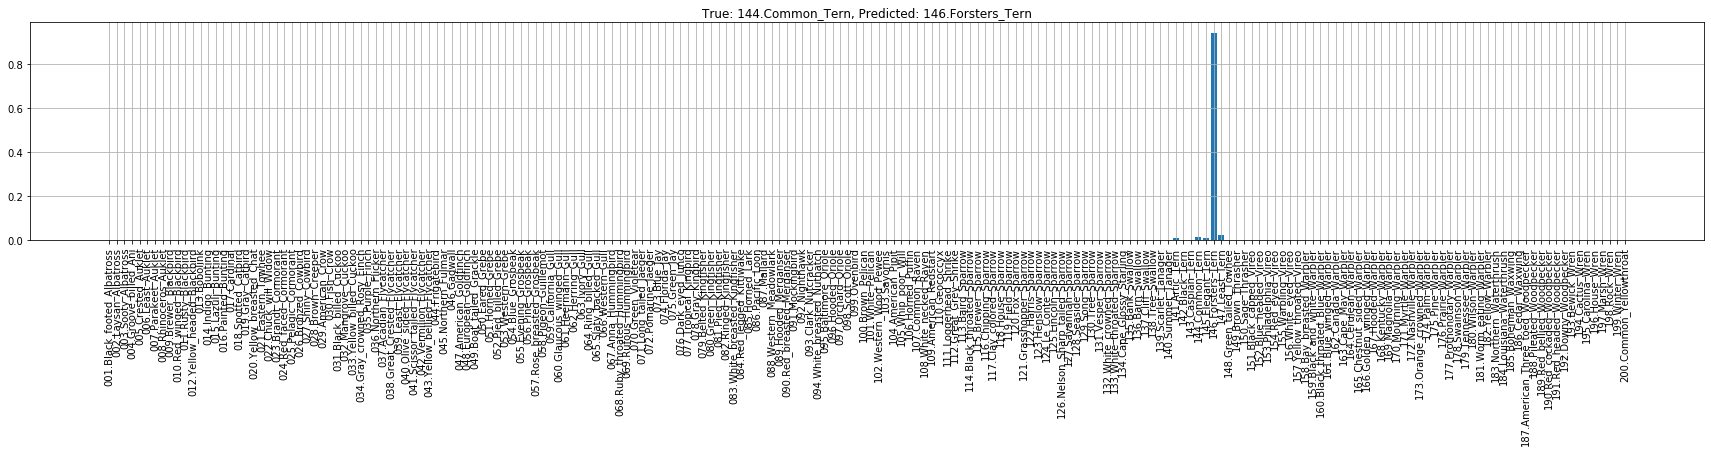

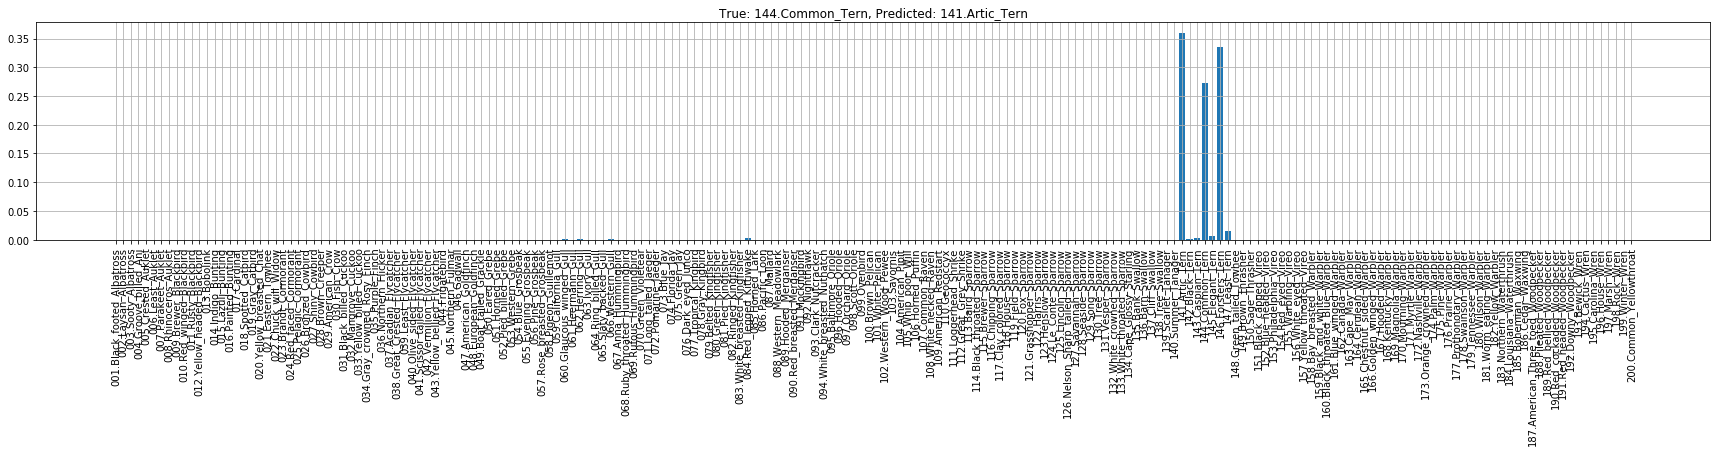

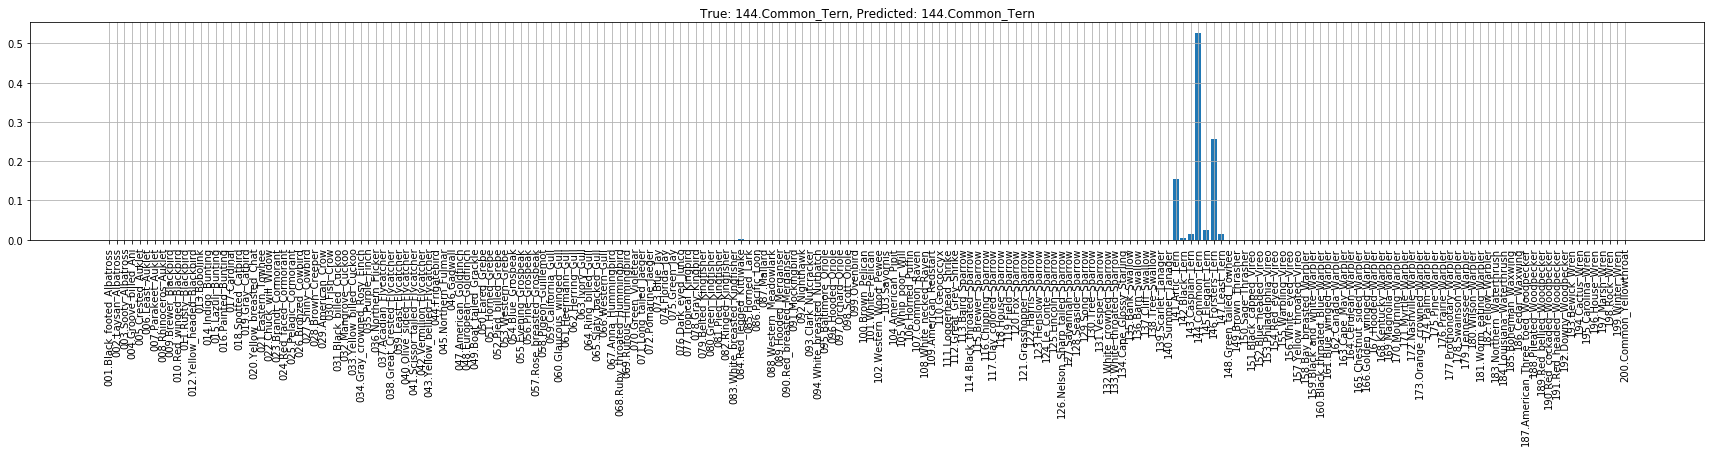

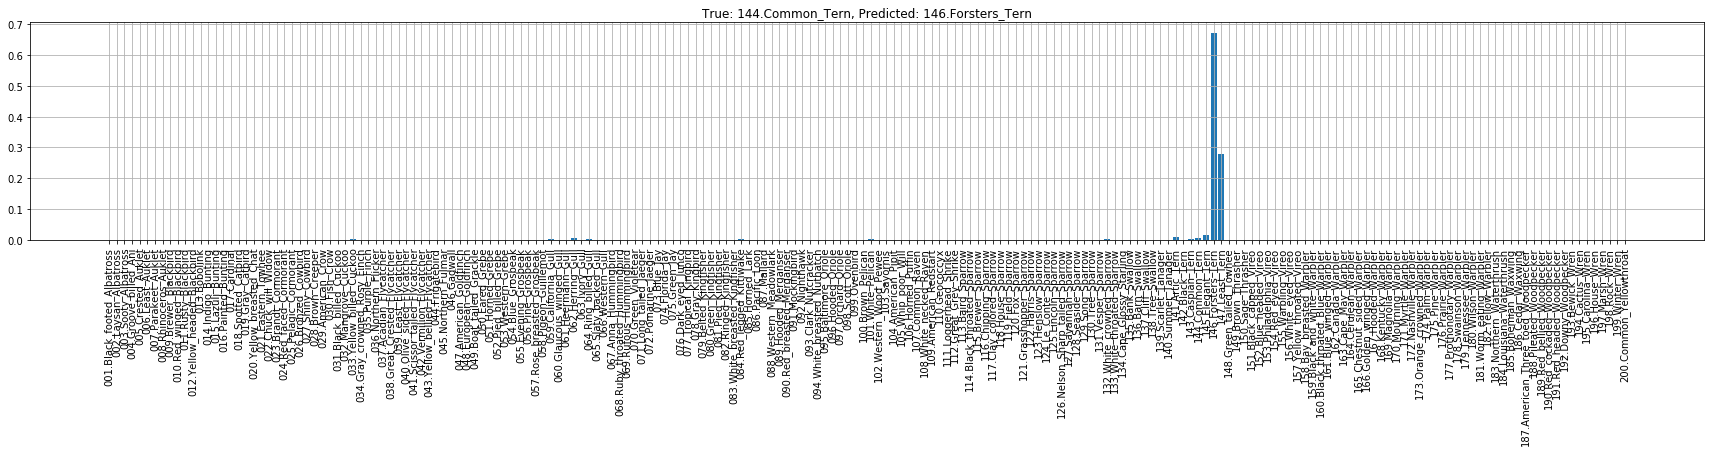

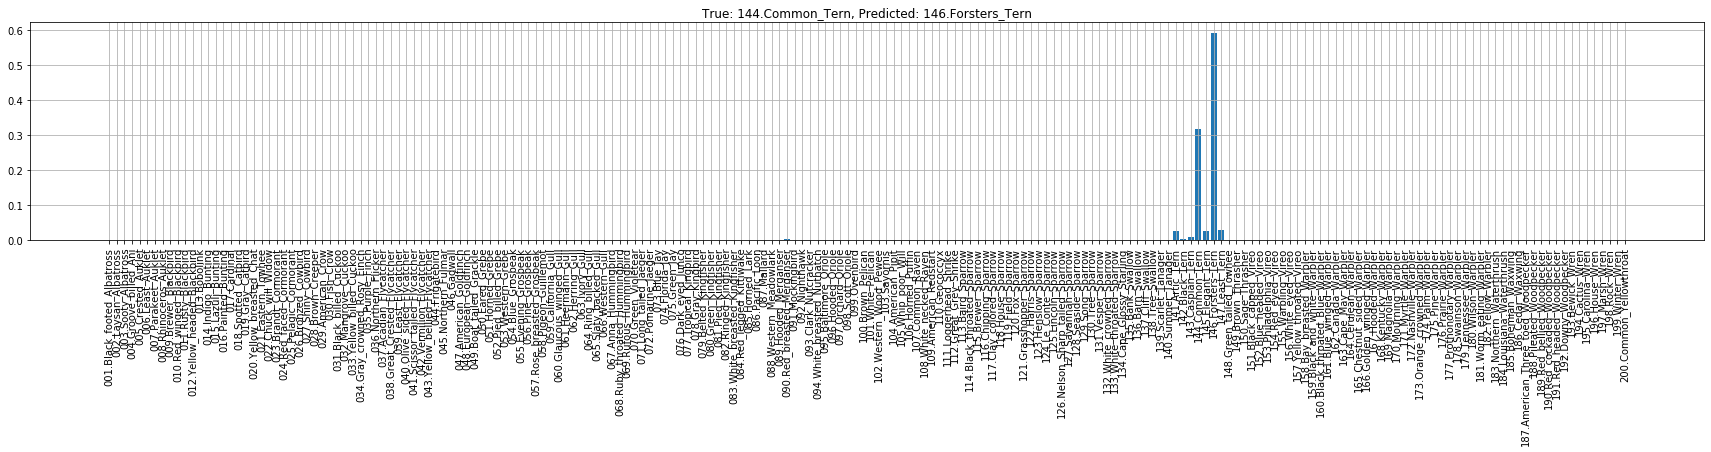

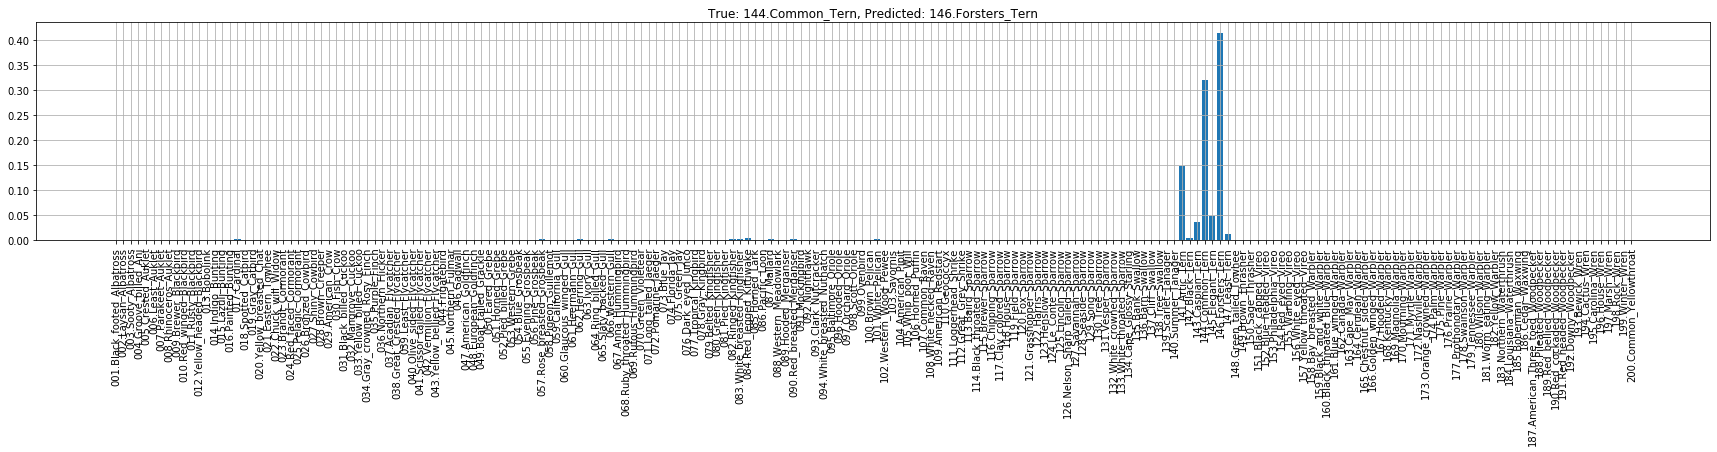

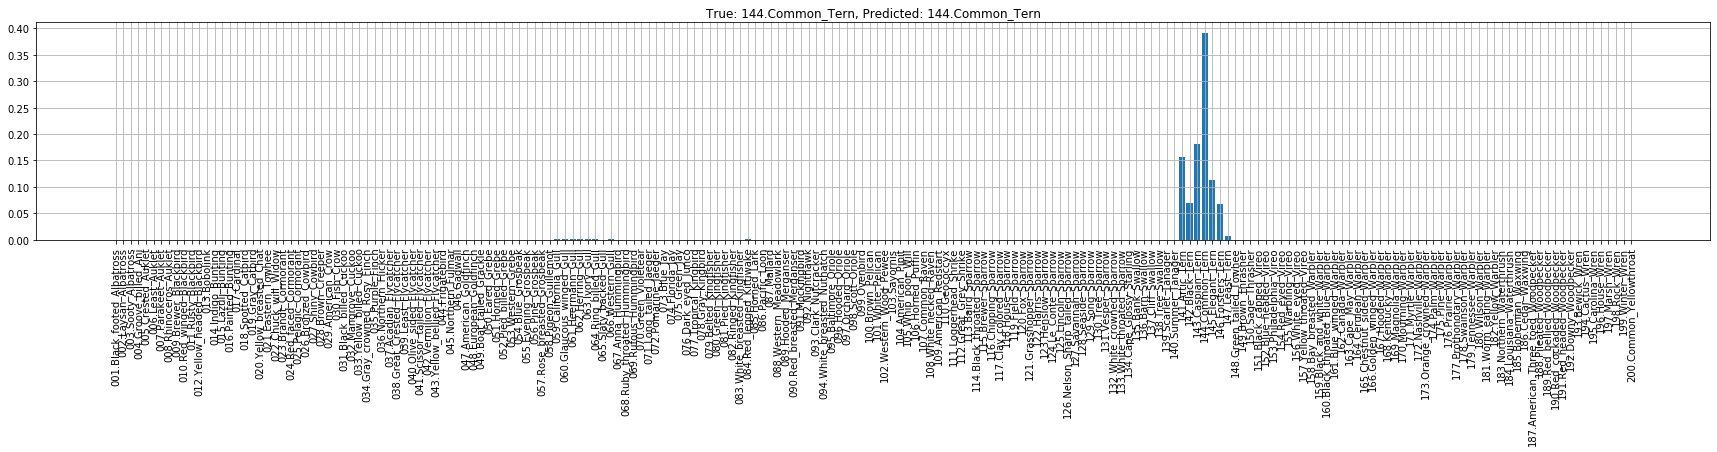

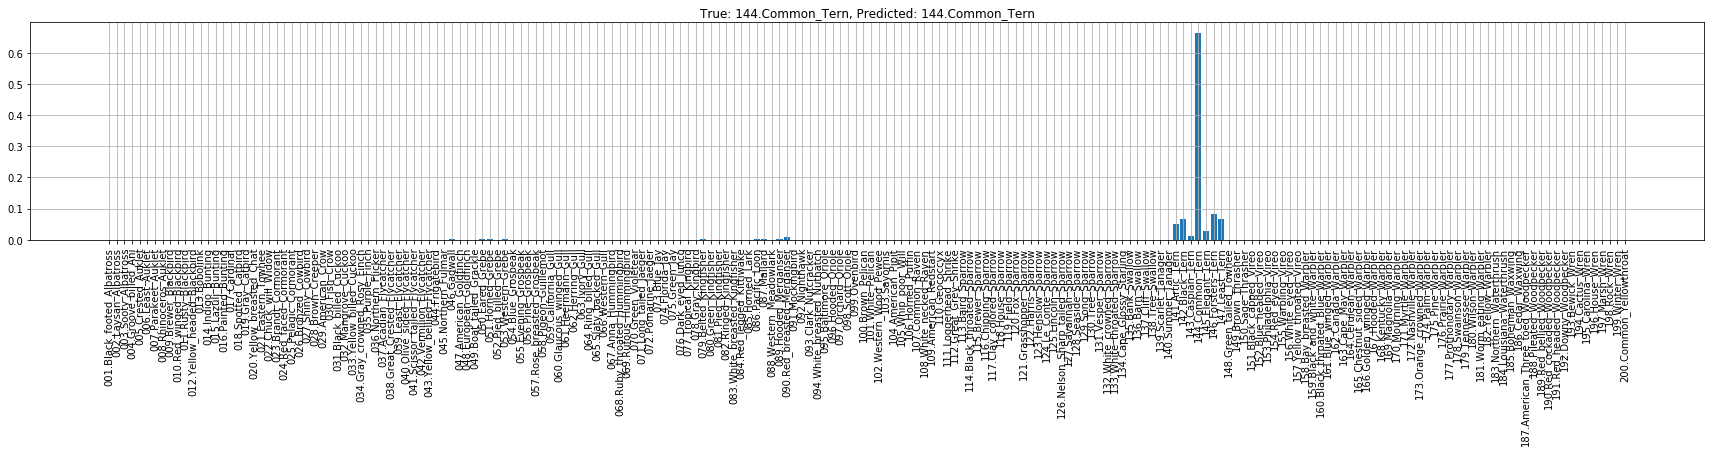

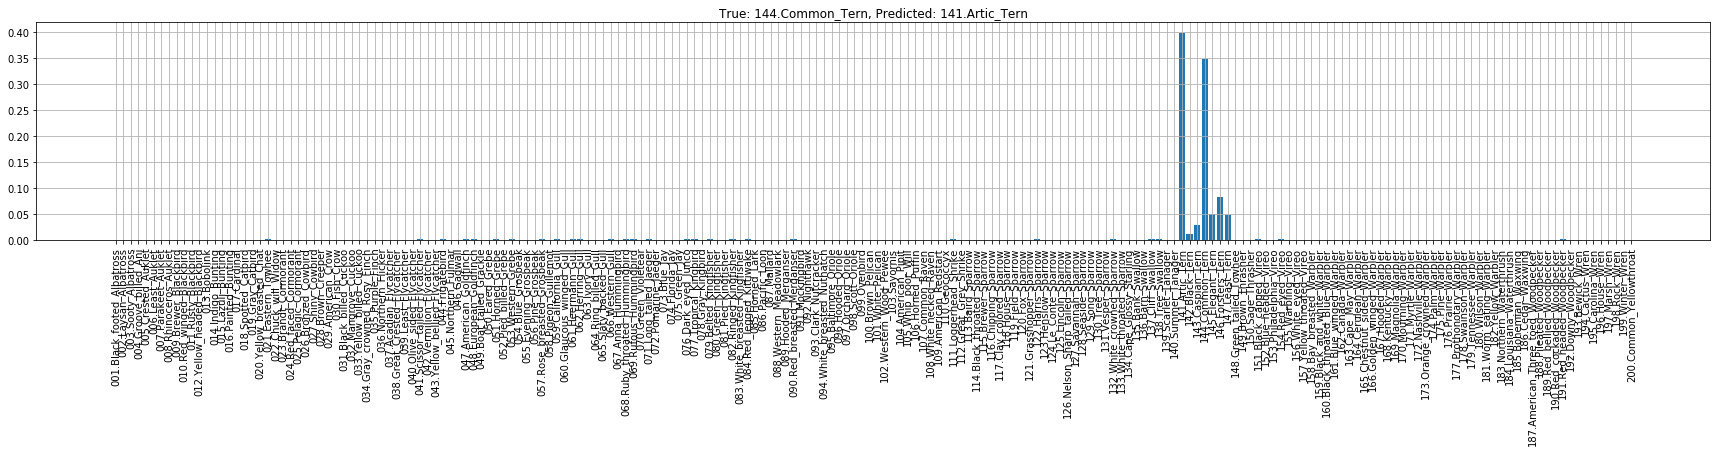

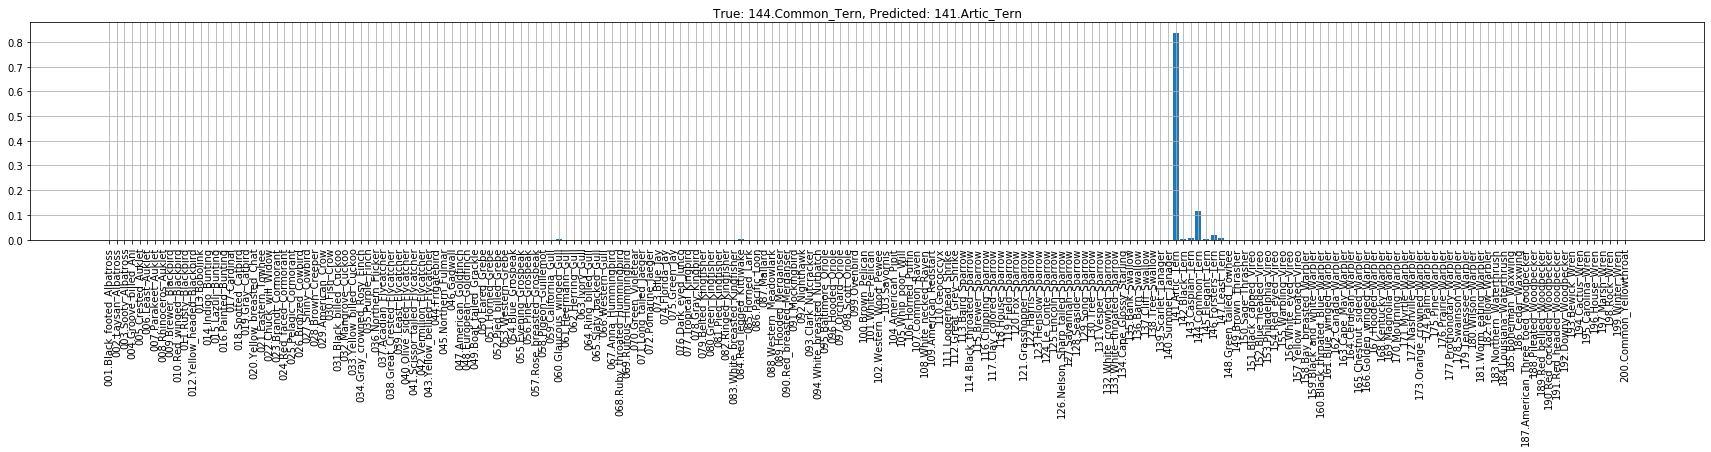

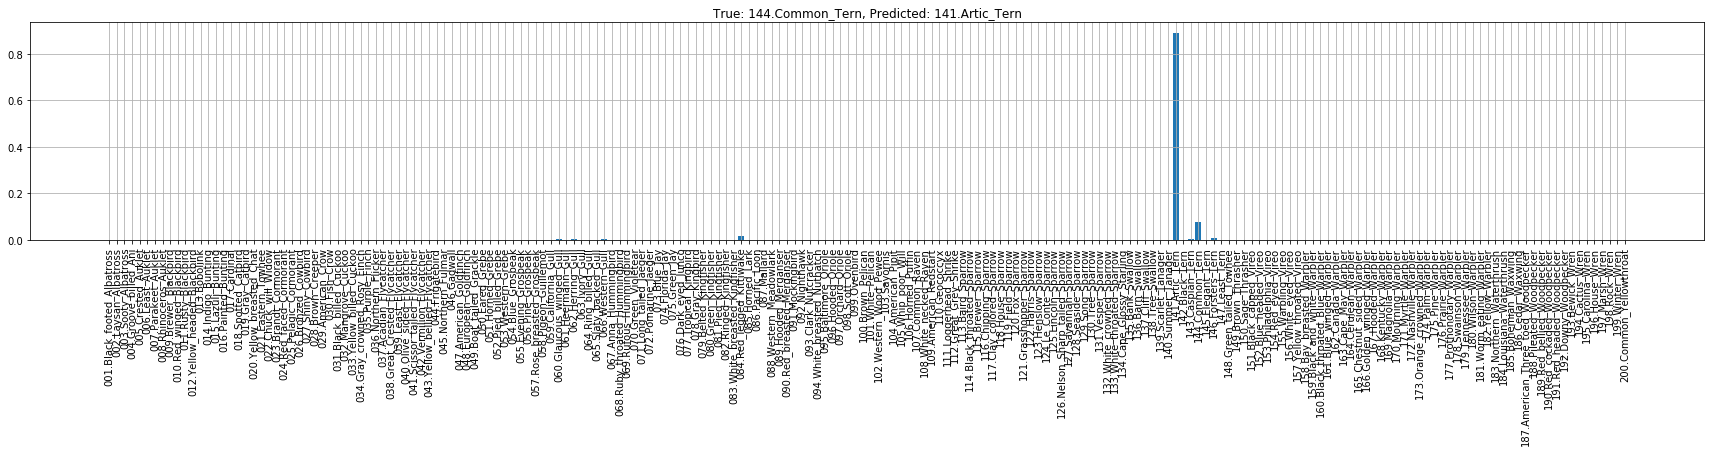

KeyboardInterrupt: 

In [100]:
class_inv = '144.Common_Tern'
for inst in np.arange(0,len(model_misclassifieds[class_inv]['labels_pred']),1):
    if np.int(model_misclassifieds[class_inv]['labels_pred'][inst]) != np.int(class_inv.split('.')[0]):
        plt.figure(figsize=(30,4))
        plt.bar(x=class_names, height=torch.nn.functional.softmax(torch.tensor(model_misclassifieds[class_inv]['scores_pred'][inst,:])).numpy())
        plt.xticks(rotation=90)
        plt.title('True: {}, Predicted: {}'.format(class_inv, class_names[model_misclassifieds[class_inv]['labels_pred'][inst]]))
        plt.grid(True)
        plt.show()

In [ ]:
class_names